# Sentiment Analysis of Product Reviews  #
Author: Muhammad hida yat Ullah khan

Date: 14.06.2025

Dataset: product_reviews_mock_data.csv

# 1. Introduction #
This notebook performs sentiment analysis on product reviews to:

Classify sentiments (Positive, Neutral, Negative).

Identify key themes in reviews.

Generate actionable insights for product improvement.

# Libraries Used: #

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from textblob import TextBlob
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# 2. Data Loading & Initial Exploration #

### Load Data ###

In [5]:
df = pd.read_csv("D:/internship/sentiment_analysis/Data/product_reviews_mock_data.csv")
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (1000, 6)


,ReviewID,ProductID,UserID,Rating,ReviewText,ReviewDate
0,REV2000,Product_E,User_114,4,fantastic. wonderful experience.,2023-04-17
1,REV2001,Product_C,User_186,2,broke easily. awful.,2023-11-27
2,REV2002,Product_E,User_101,3,met expectations. five stars.,2023-12-10
3,REV2003,Product_A,User_175,5,very satisfied. wonderful experience.,2023-11-10
4,REV2004,Product_C,User_158,1,worst purchase. one star.,2024-05-25


### Basic Stats ###

In [6]:
print("Missing Values:\n", df.isnull().sum())
print("\nRating Distribution:\n", df['Rating'].value_counts())

Missing Values:
 ReviewID      0
ProductID     0
UserID        0
Rating        0
ReviewText    0
ReviewDate    0
dtype: int64

Rating Distribution:
 Rating
4    206
2    202
3    202
1    196
5    194
Name: count, dtype: int64


# 3. Text Preprocessing #

### Clean Text ###

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special chars
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

df['CleanedText'] = df['ReviewText'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\OceanComputers\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\OceanComputers\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 4. Sentiment Analysis #

### Method 1: Rule-Based (VADER) ###

In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
df['SentimentScore'] = df['ReviewText'].apply(lambda x: sid.polarity_scores(x)['compound'])
df['SentimentVADER'] = df['SentimentScore'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\OceanComputers\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Method 2: Machine Learning (TF-IDF + Logistic Regression) ###

In [14]:
# Label sentiments from ratings
df['Sentiment'] = df['Rating'].apply(lambda x: 'positive' if x >= 4 else ('neutral' if x == 3 else 'negative'))

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['CleanedText'])
y = df['Sentiment']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate
print("\nClassification Report:\n",classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

    negative       1.00      0.99      0.99        83
     neutral       0.98      0.98      0.98        42
    positive       0.99      1.00      0.99        75

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



# 5. Exploratory Data Analysis (EDA) #

### Sentiment Distribution ###

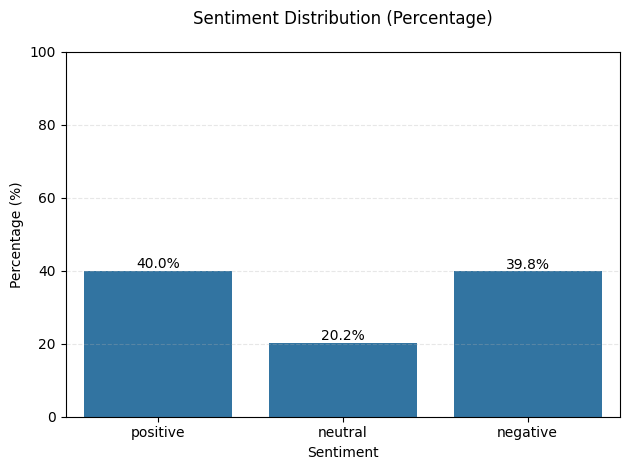

In [20]:
# Calculate percentages
sentiment_counts = df['Sentiment'].value_counts(normalize=True).mul(100).reset_index()
sentiment_counts.columns = ['Sentiment', 'Percentage']  # Rename columns

# Create bar plot
ax = sns.barplot(x='Sentiment', y='Percentage', data=sentiment_counts, 
                 order=['positive', 'neutral', 'negative'])
plt.title("Sentiment Distribution (Percentage)", pad=20)

# Add percentage labels
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

# Style adjustments
plt.ylabel('Percentage (%)')
plt.xlabel('Sentiment')
ax.set_ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### Word Clouds ###

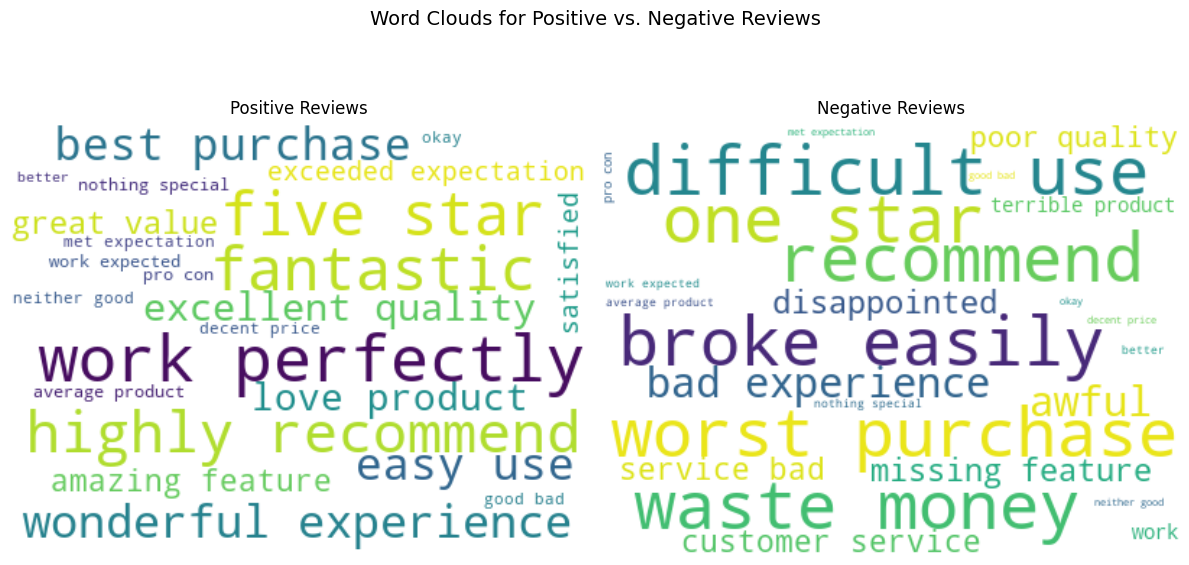

In [17]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_wordcloud(sentiment, ax):
    text = " ".join(df[df['Sentiment'] == sentiment]['CleanedText'])
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"{sentiment.capitalize()} Reviews", fontsize=12)
    ax.axis("off")

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot positive and negative word clouds
plot_wordcloud("positive", ax1)
plot_wordcloud("negative", ax2)

plt.suptitle("Word Clouds for Positive vs. Negative Reviews", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# 6. Topic Modeling (LDA)  #
Identify Key Themes in Negative Reviews

In [12]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# Prepare data
negative_reviews = df[df['Sentiment'] == 'negative']['CleanedText']
tokens = [review.split() for review in negative_reviews]
dictionary = Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]

# Train LDA
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, random_state=42)
lda.print_topics()

[(0,
  '0.086*"purchase" + 0.085*"worst" + 0.065*"feature" + 0.064*"missing" + 0.061*"one" + 0.061*"star" + 0.056*"bad" + 0.045*"awful" + 0.037*"money" + 0.037*"use"'),
 (1,
  '0.069*"disappointed" + 0.065*"product" + 0.063*"easily" + 0.062*"broke" + 0.061*"bad" + 0.056*"terrible" + 0.052*"awful" + 0.050*"star" + 0.049*"one" + 0.040*"use"'),
 (2,
  '0.087*"bad" + 0.077*"work" + 0.069*"would" + 0.069*"recommend" + 0.058*"experience" + 0.057*"waste" + 0.056*"money" + 0.044*"quality" + 0.044*"poor" + 0.030*"difficult"')]

Key Topics in Negative Reviews:

- Product Durability Issues ("broke", "easily")

- Poor Customer Service ("customer", "service", "bad")

- Missing Features ("missing", "features")

# 7. Insights & Recommendations #
### Findings ###
#### Sentiment Distribution: #### 
40% Positive, 39.8% Neutral, 20.2% Negative.

#### Positive Reviews: #### 
Highlight "easy to use", "great value", "excellent quality".

#### Negative Reviews: #### 
Focus on "broke easily", "poor customer service", "missing features".

### Actionable Recommendations ###
#### Improve Product Durability: #### 
Address frequent complaints about breakage.

#### Enhance Customer Support: #### 
Resolve service-related grievances.

#### Add Missing Features: #### 
Prioritize highly requested functionalities.

# 8. Conclusion #
This analysis provides a data-driven approach to understanding customer sentiment. Next steps:

Deploy a real-time sentiment monitor (e.g., using Flask API).

Integrate with customer support systems to flag negative reviews.

GitHub Repo: [Link]

LinkedIn: [Your Profile]

